# Data-based time series prediction

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

## Data
### Real data Germany

In [2]:
rki_covid_data = pd.read_csv("../../Week 5/RKI_COVID19.csv", header=0, sep=",")
# create a column containing the date
rki_covid_data["Date"] = pd.to_datetime(rki_covid_data['Refdatum'], format='%Y/%m/%d %H:%M:%S.%f')
rki_covid_data["Date"] = rki_covid_data['Date'].dt.date
rki_covid_data.head()

,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,Date
0,8389847,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/14 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt,2020-03-16
1,8389848,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt,2020-03-13
2,8389849,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt,2020-03-16
3,8389850,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/21 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt,2020-03-13
4,8389851,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/27 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/22 00:00:00,0,1,1,Nicht übermittelt,2020-03-22


In [3]:
print(rki_covid_data["AnzahlTodesfall"].unique())
print(rki_covid_data["AnzahlFall"].unique())
print(rki_covid_data["NeuerFall"].unique())

[ 0  1  3  2  6  4  5  7  8 -1]
[ 1  2  3  4  7 11  6 13  9  5 19  8 10 15 12 -1 18 14 16 17 29 22 23 32
 20 34 62 38 26 27 21 31 24 33 25 28]
[ 0  1 -1]


In [4]:
# filter the dataframe for deaths per day by multiplying entries by the number of deaths they count
#cases_per_day_pre = rki_covid_data[rki_covid_data['NeuerFall'].isin([0,1])].groupby("Date")['AnzahlFall'].value_counts()
#cases_per_day = pd.DataFrame(index=cases_per_day_pre.index.get_level_values('Date'))
#cases_per_day["Cases"] = 0
#for date in cases_per_day.index:
#    for level in cases_per_day_pre.loc[date].index.get_level_values(0):
#        cases_per_day.at[date, "Cases"] = cases_per_day.at[date, "Cases"] + level * cases_per_day_pre.loc[date, level]

cases_per_day = rki_covid_data[rki_covid_data['NeuerFall'].isin([0,1])].groupby("Date", as_index=True).AnzahlFall.sum()
 # drop all dates before 2020/3/1 and after 2020/04/20
data = cases_per_day[datetime.date(2020,3,1):datetime.date(2020,4,30)]
data_unique = data.drop_duplicates()
data_unique.shape

(61,)

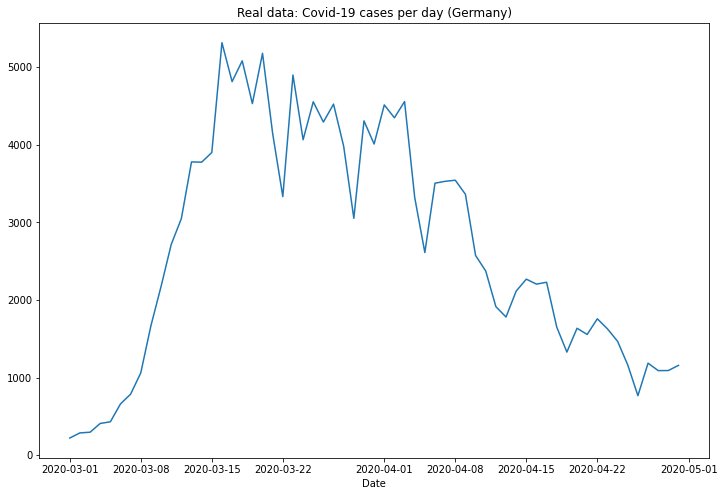

In [5]:
data_unique.plot(figsize=(12, 8), title="Real data: Covid-19 cases per day (Germany)")
plt.show()

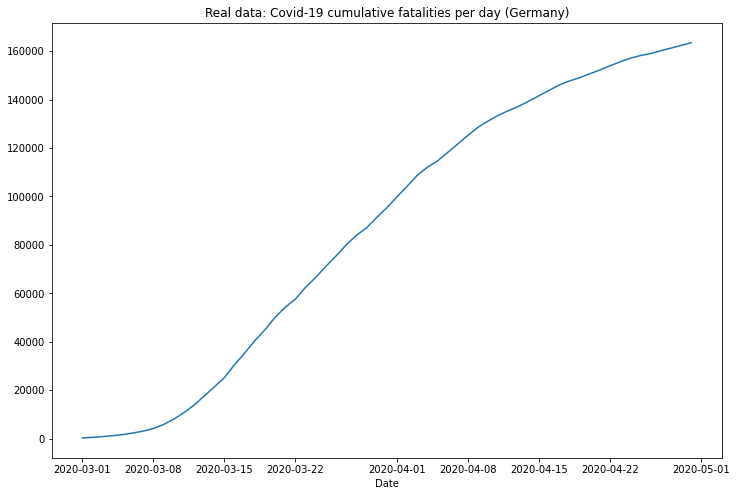

In [6]:
data_unique.cumsum().plot(figsize=(12, 8), title="Real data: Covid-19 cumulative fatalities per day (Germany)")
plt.show()

__Stationarity__<br>
Check for constant mean, constant variance and an auto co-variance that does not depend on time.<br>
Apply Dickey-Fuller-Test for stationarity.
Reasons for non-stationarity:
- Trend = non-constant mean
- Seasonality = variation at specific time-frames

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, season_window):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=season_window).mean()
    rolstd = pd.Series(timeseries).rolling(window=season_window).std()
#Plot rolling statistics:
    fig = plt.figure(figsize=(18,7))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

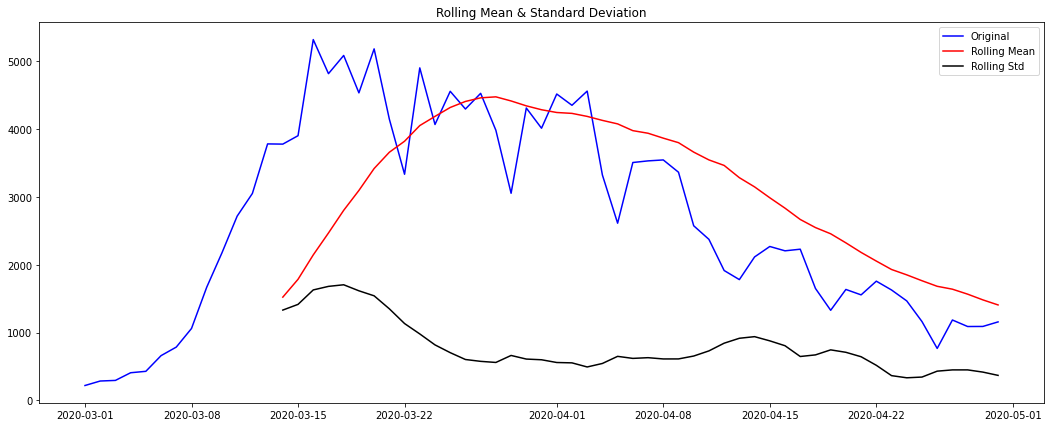

Results of Dickey-Fuller Test:
Test Statistic                 -2.480997
p-value                         0.120167
#Lags Used                      8.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [8]:
test_stationarity(data_unique, 14)

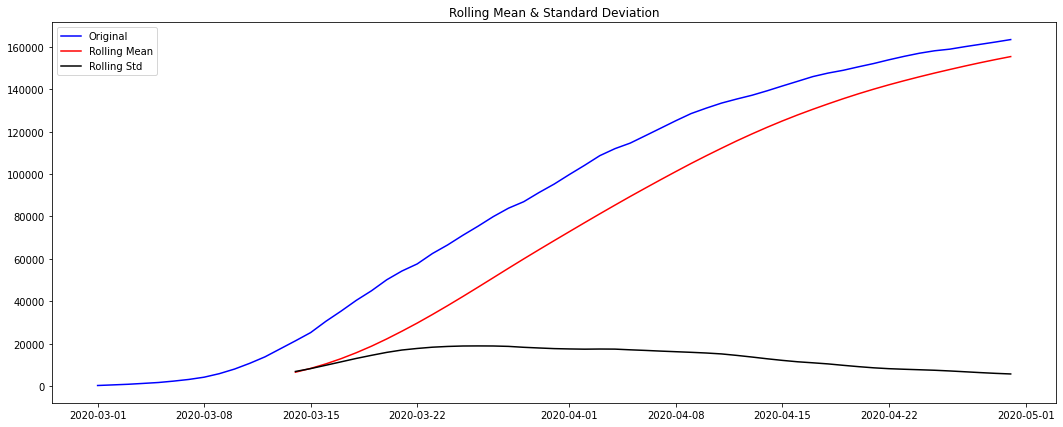

Results of Dickey-Fuller Test:
Test Statistic                 -3.802859
p-value                         0.002878
#Lags Used                      8.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [9]:
test_stationarity(data_unique.cumsum(), 14)

__Train and prediction set__ 

In [10]:
data_train = cases_per_day[datetime.date(2020,3,1):datetime.date(2020,4,20)]
data_test = cases_per_day[datetime.date(2020,4,21):datetime.date(2020,4,30)]
data_train.shape, data_test.shape
data_train_unique = data_train.drop_duplicates()
data_test_unique = data_test.drop_duplicates()
print(data_train_unique.shape, data_test_unique.shape)

(51,) (10,)


### SEICRD generated data
See assignment week 5:
- SEICRD model was fit to rki real case data (GER) (based on reported cases, from 2020/3/1 until 2020/05/21)
- generated data from scenario without any measures over range of 200 (from 2020/01/31 to 2020/11/5 including outbreak shift)
- took only numbers from 'Infectious' compartment


In [11]:
#SIR_data = pd.read_csv('SIR_generated_data.csv')
SIR_data = pd.read_csv('../correct_counting_for_rki_dataset_and_SEICRD/SEICRD_daily.csv')
SIR_data.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
SIR_data["Date"] = pd.to_datetime(SIR_data['Date'], format='%Y/%m/%d %H:%M:%S.%f')
SIR_data["Date"] = SIR_data['Date'].dt.date

In [12]:
#SIR_data.Cases = SIR_data.Cases.round(0).astype('int')
#SIR_data = SIR_data.set_index('Date')
SIR_data.I = SIR_data.I.round(0).astype("int")
SIR_data = SIR_data.set_index("Date")
SIR_data.index.min(), SIR_data.index.max()

(datetime.date(2020, 3, 1), datetime.date(2020, 5, 21))

In [13]:
SIR_data = SIR_data[datetime.date(2020,3,1):datetime.date(2020,4,30)]

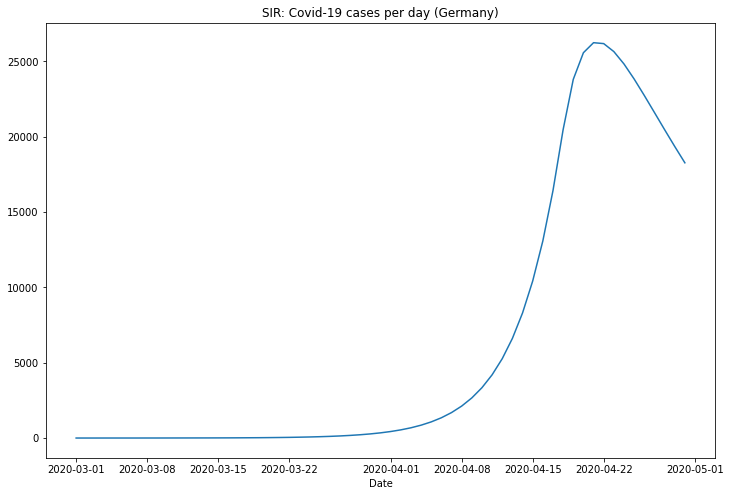

In [14]:
#SIR_data.plot(figsize=(12, 8), title="SIR: Covid-19 cases per day (Germany)")
SIR_data.I.plot(figsize=(12, 8), title="SIR: Covid-19 cases per day (Germany)")
plt.show()

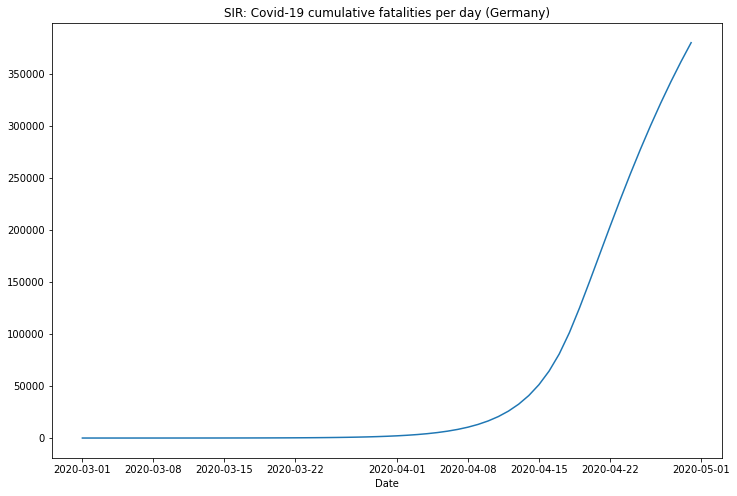

In [15]:
#SIR_data.cumsum().plot(figsize=(12, 8), title="SIR: Covid-19 cumulative fatalities per day (Germany)")
SIR_data.I.cumsum().plot(figsize=(12, 8), title="SIR: Covid-19 cumulative fatalities per day (Germany)")
plt.show()

__Stationarity__

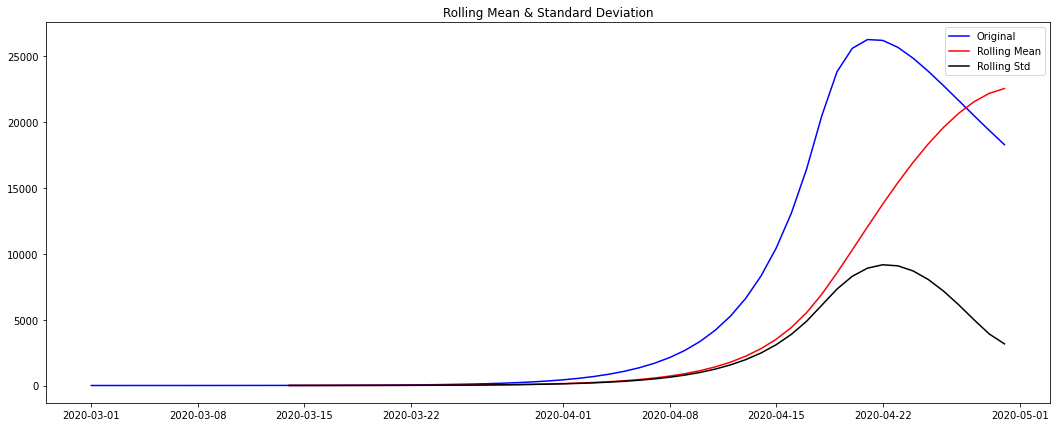

Results of Dickey-Fuller Test:
Test Statistic                 -1.355955
p-value                         0.603200
#Lags Used                      5.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


In [16]:
test_stationarity(SIR_data.I, 14)

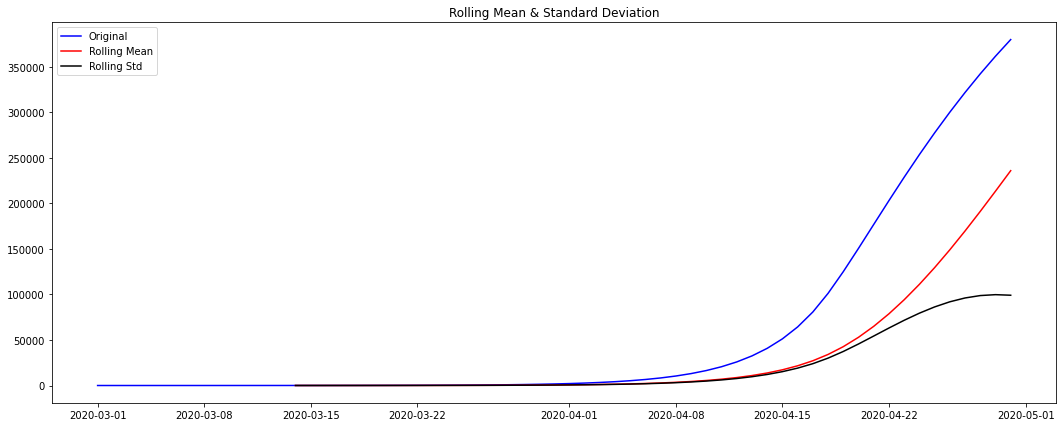

Results of Dickey-Fuller Test:
Test Statistic                  0.495435
p-value                         0.984734
#Lags Used                      6.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


In [17]:
test_stationarity(SIR_data.I.cumsum(), 14)

__Train and prediction set__

In [18]:
SIR_data_train = SIR_data[datetime.date(2020, 3, 1):datetime.date(2020, 4, 20)]
SIR_data_test = SIR_data[datetime.date(2020, 4, 21):datetime.date(2020, 4, 30)]

In [19]:
SIR_data_train.shape, SIR_data_test.shape

((51, 6), (10, 6))

### ABS-generated data
See assignment week 6:
- Corona abs without measures and the following parameters:
    - initial_infected_perc = 0.02,
    - initial_immune_perc = 0.01,
    - population_size=1000,
    - condition_perc=0.05,
    - contagion_distance=5., 
    - contagion_rate=0.5,               
    - critical_limit=0.10,
    - amplitudes = {Status.Susceptible : 5, Status.Recovered_Immune : 5, Status.Infected : 5 },
    - store_infection_rate = 0.6, 
    - stores_per_thousand = 4,
    - days_without_shopping = 4 
    - simulation duration = 100 days

In [20]:
#ABS_data = pd.read_csv('../../Week 6/scenarios/scenario1.csv')
ABS_data = pd.read_csv('../correct_counting_for_rki_dataset_and_SEICRD/do_nothing_reduced.csv')

In [21]:
ABS_data.columns

Index(['Iteration', 'Metric', 'Min', 'Avg', 'Std', 'Max'], dtype='object')

In [22]:
ABS_infected = ABS_data[ABS_data.Metric=="Infected"]
ABS_infected['case_count'] = ABS_infected.Avg*1000
ABS_infected.case_count = ABS_infected.case_count.astype(int)
ABS_infected.set_index('Iteration', inplace=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


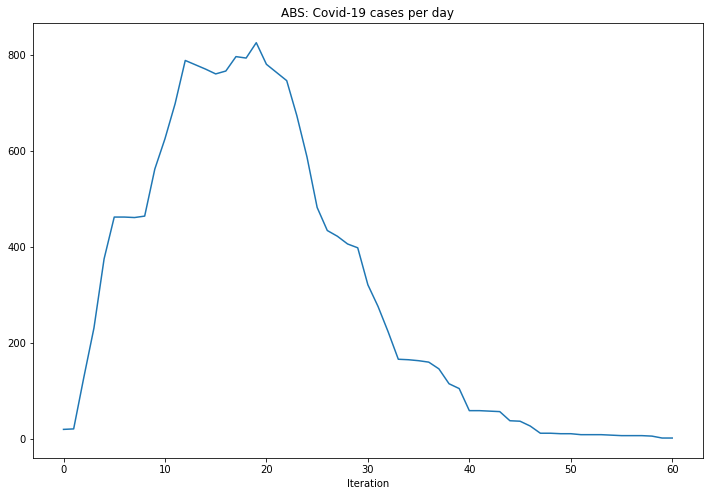

In [23]:
ABS_infected['case_count'].iloc[0:61].plot(figsize=(12, 8), title="ABS: Covid-19 cases per day")
plt.show()

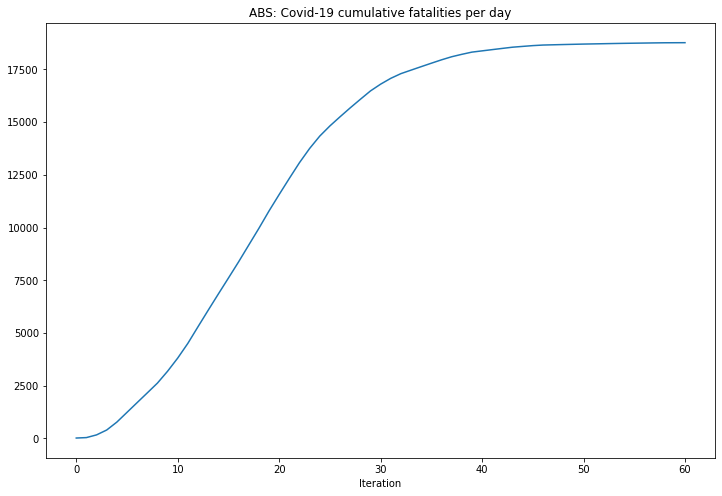

In [24]:
ABS_infected['case_count'].iloc[0:61].cumsum().plot(figsize=(12, 8), title="ABS: Covid-19 cumulative fatalities per day")
plt.show()

__Stationarity__

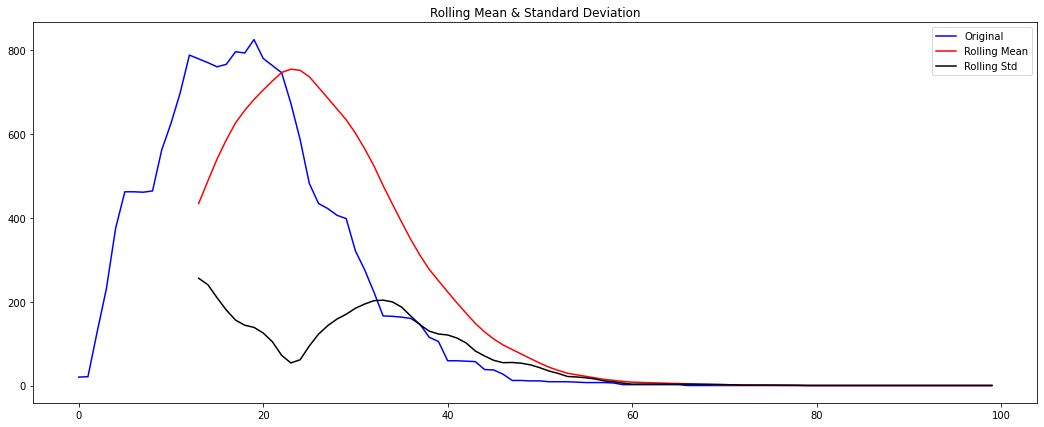

Results of Dickey-Fuller Test:
Test Statistic                 -2.675139
p-value                         0.078440
#Lags Used                     11.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64


In [25]:
test_stationarity(ABS_infected['case_count'], 14)

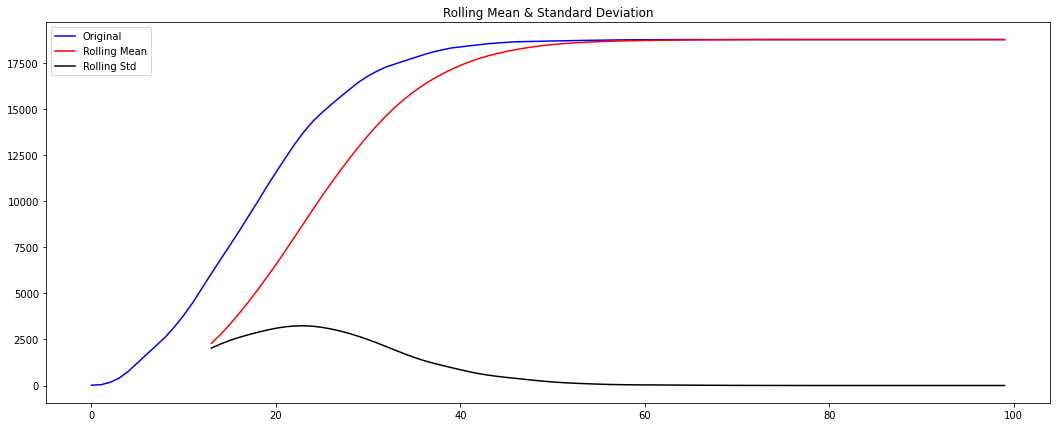

Results of Dickey-Fuller Test:
Test Statistic                 -3.848035
p-value                         0.002452
#Lags Used                     12.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64


In [26]:
test_stationarity(ABS_infected['case_count'].cumsum(), 14)

__Train and prediction set__

In [27]:
ABS_infected_train = ABS_infected[ABS_infected.index<=51]
ABS_infected_test = ABS_infected[ABS_infected.index>51]
ABS_infected_test = ABS_infected_test[ABS_infected_test.index<62]

In [28]:
ABS_infected_train.shape, ABS_infected_test.shape

((52, 6), (10, 6))

## "Classical" time-series prediction approach
The Holt Winter’s Exponential Smoothing (HWES) also called the Triple Exponential Smoothing method models the next time step as an exponentially weighted linear function of observations at prior time steps, taking trends and seasonality into account.

The method is suitable for univariate time series with trend and/or seasonal components.
(https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/)


- The real data contains trend and seasonailty effects
- Perform grid search to find the best model settings for time series prediction on the real data
- Estimate seasonal and trend components

In [29]:
# grid search ets models for monthly car sales
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from numpy import array
 
# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
	t,d,s,p,b,r = config
	# define model
	history = array(history)
	model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
	model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = exp_smoothing_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error
 
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)
 
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores
 
# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
	models = list()
	# define config lists
	t_params = ['add', 'mul', None]
	d_params = [True, False]
	s_params = ['add', 'mul', None]
	p_params = seasonal
	b_params = [True, False]
	r_params = [True, False]
	# create config instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for b in b_params:
						for r in r_params:
							cfg = [t,d,s,p,b,r]
							models.append(cfg)
	return models

__Real data__

In [39]:
if __name__ == '__main__':
	# load dataset
	#series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
	#data = series.values
	# data split
	n_test = 10
	# model configs
	cfg_list = exp_smoothing_configs(seasonal=[0,7,14])
	# grid search
	scores = grid_search(data_train_unique.cumsum(), cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

KeyboardInterrupt: 

In [40]:
# HWES example
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# fit model
# optimal model configuration:
# ['mul', True, None, 0, True, True] 318.58164668033527
# ['mul', True, None, 7, True, True] 318.58164668033527
# ['mul', True, None, 14, True, True] 318.58164668033527
model = ExponentialSmoothing(data_train_unique.cumsum(), trend='mul', damped=True, seasonal=None, seasonal_periods=0)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(datetime.date(2020,3,3), datetime.date(2020,4,30))


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


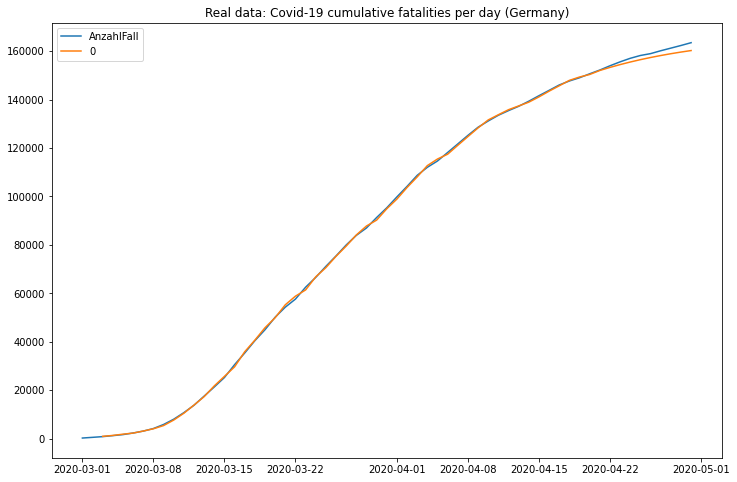

In [41]:
pd.concat([data_unique.cumsum(), yhat],axis=1).plot(figsize=(12, 8), title="Real data: Covid-19 cumulative fatalities per day (Germany)")
plt.show()

__SIR data__

In [44]:
if __name__ == '__main__':
	# load dataset
	#series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
	#data = series.values
	# data split
	n_test = 10
	# model configs
	cfg_list = exp_smoothing_configs(seasonal=[0,7,14])
	# grid search
	scores = grid_search(SIR_data_train.I.cumsum(), cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[['add', True, None, 0, False, True]] 2201.545
 > Model[['add', True, None, 0, False, False]] 2450.203
 > Model[['add', True, None, 7, False, True]] 2201.545
 > Model[['add', True, None, 7, False, False]] 2450.203
 > Model[['add', True, None, 14, False, True]] 2201.545
 > Model[['add', True, None, 14, False, False]] 2450.203
 > Model[['add', False, 'add', 7, False, True]] 2200.862
 > Model[['add', False, 'add', 7, False, False]] 2449.315
 > Model[['add', False, 'add', 14, False, True]] 2200.583
 > Model[['add', False, 'add', 14, False, False]] 2448.747
 > Model[['add', False, None, 0, False, True]] 2200.477
 > Model[['add', False, None, 0, False, False]] 2449.012
 > Model[['add', False, None, 7, False, True]] 2200.477
 > Model[['add', False, None, 7, False, False]] 2449.012
 > Model[['add', False, None, 14, False, True]] 2200.477
 > Model[['add', False, None, 14, False, False]] 2449.012
 > Model[[None, False, 'add', 7, False, True]] 13965.520
 > Model[[None, False, 'add', 7, Fa

In [45]:
# HWES example
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# fit model
# optimal model configuration:
# ['add', False, None, 0, False, True] 2200.476932542748
# ['add', False, None, 7, False, True] 2200.476932542748
# ['add', False, None, 14, False, True] 2200.476932542748
model = ExponentialSmoothing(SIR_data_train.I.cumsum(), trend='add', damped=False, seasonal=None, seasonal_periods=0)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(datetime.date(2020,3,1), datetime.date(2020,4,30))


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


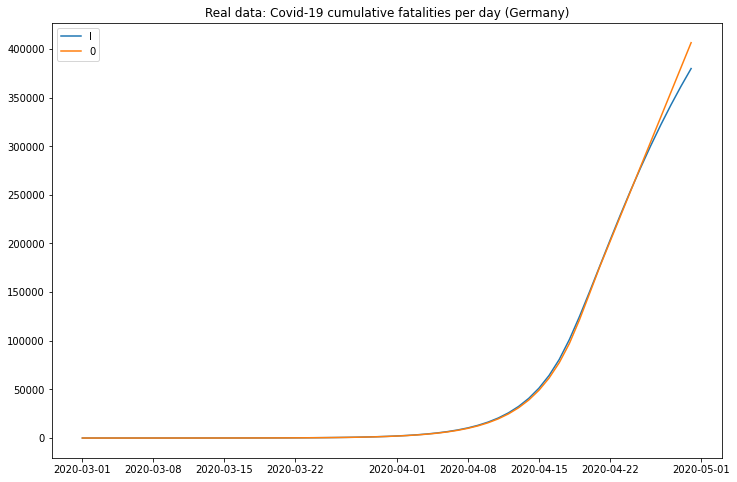

In [52]:
pd.concat([SIR_data.I.cumsum(), yhat],axis=1).plot(figsize=(12, 8), title="SIR data: Covid-19 cumulative fatalities per day (Germany)")
plt.show()

__ABS data__

In [53]:
if __name__ == '__main__':
	# load dataset
	#series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
	#data = series.values
	# data split
	n_test = 10
	# model configs
	cfg_list = exp_smoothing_configs(seasonal=[0,7,14])
	# grid search
	scores = grid_search(ABS_infected_train["case_count"].cumsum(), cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

done


In [63]:
# HWES example
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# fit model
# optimal model configuration:
# 
model = ExponentialSmoothing(ABS_infected_train['case_count'].cumsum(), trend='add', damped=False, seasonal=None, seasonal_periods=0)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(51,61)


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


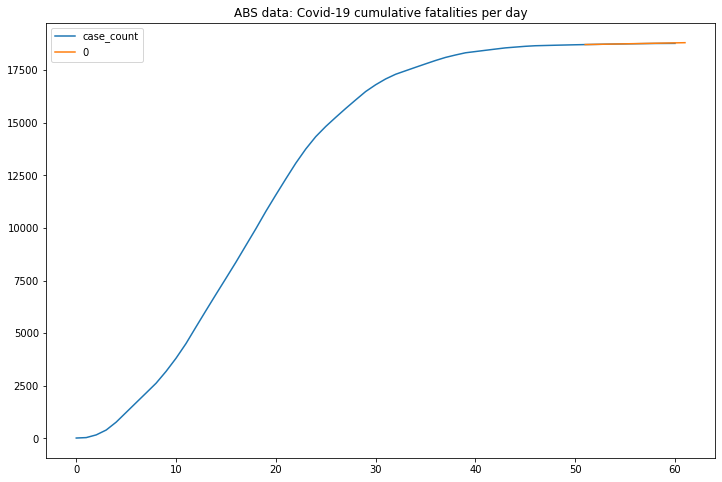

In [65]:
pd.concat([ABS_infected.iloc[0:61]['case_count'].cumsum(), yhat],axis=1).plot(figsize=(12, 8), title="ABS data: Covid-19 cumulative fatalities per day")
plt.show()

## Prophet library

In [267]:
!pip install fbprophet
import fbprophet

  Using cached fbprophet-0.6.tar.gz (54 kB)
     |████████████████████████████████| 1.9 MB 1.3 MB/s eta 0:00:01
  Using cached cmdstanpy-0.4.0-py3-none-any.whl (22 kB)
  Using cached pystan-2.19.1.1-cp37-cp37m-macosx_10_6_intel.whl (39.1 MB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.2.1-py2.py3-none-any.whl (43 kB)
Processing /Users/Eva/Library/Caches/pip/wheels/90/4e/82/f4130a57eb035c4344489ca14caff692590719b5f375540f53/holidays-0.10.2-py3-none-any.whl
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached ephem-3.7.7.1-cp37-cp37m-macosx_10_6_intel.whl (1.5 MB)
Processing /Users/Eva/Library/Caches/pip/wheels/80/32/5f/2a67880d4ce584b9cf99146f9945e46942dfb010a9382c6ff5/PyMeeus-0.3.7-py3-none-any.whl
  Using cached korean_lunar_calendar-0.2.1-py3-none-any.whl (8.0 kB)
  ERROR: Command errored out with exit status 1:
   command: /opt/miniconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/

ModuleNotFoundError: No module named 'fbprophet'

## LSTM